In [1]:
import astroquery
from astropy.coordinates import SkyCoord
import astropy.units as u
from astroquery.gaia import Gaia
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from astropy.io import fits
import aplpy
from astropy.wcs import WCS
from astropy.coordinates import Angle
import astroalign as aa
from astropy.modeling.projections import Pix2Sky_Gnomonic, Sky2Pix_Gnomonic
from astropy.visualization import ZScaleInterval

Created TAP+ (v1.2.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443
Created TAP+ (v1.2.1) - Connection:
	Host: geadata.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443


In [23]:
# Reference image
refpath = "./wcstestdata/IC2143_wcs.fits"
hdulist = fits.open(refpath)
refimg = hdulist[0].data

h, w = refimg.shape
refwcs = WCS(hdulist[0])
cra, cdec = refwcs.all_pix2world([[w/2, h/2]], 0, ra_dec_order=True)[0]
# point = SkyCoord("05h35m17.3s -05d23m28s", frame='icrs')
frame_center = SkyCoord(cra, cdec, unit='deg')
fov_rad = 10 * u.arcminute

# Get sources from GAIA

In [ ]:
MAX_REF_STARS = 50
q = Gaia.cone_search_async(frame_center, fov_rad)
result_table = q.get_results()
result_table.sort("phot_g_mean_mag")
result_table = result_table[:MAX_REF_STARS]

In [ ]:
ra_refobjs = []
dec_refobjs = []
for rastr, decstr in zip(result_table["ra"], result_table["dec"]):
    obj_ra = Angle(rastr, unit="degree")
    obj_dec = Angle(decstr, unit="degree")
    ra_refobjs.append(obj_ra.degree)
    dec_refobjs.append(obj_dec.degree)

In [ ]:
fig = aplpy.FITSFigure(hdulist[0])
fig.show_grayscale()
fig.add_grid()
fig.show_markers(ra_refobjs, dec_refobjs, layer='marker_set_1', edgecolor='red',
                facecolor='none', marker='o', s=50, alpha=0.5)
fig.show_markers(frame_center.ra.degree, frame_center.dec.degree, layer='marker_set_2', edgecolor='green',
                facecolor='none', marker='*', s=100, alpha=0.5)
plt.show()

In [ ]:
# The x, y of each object in the catalog according to the gnomonic projection
# I also keep a record of x,y to ra,dec pairs
xs = []
ys = []
cat_lookup = {}
for ra, dec in zip(ra_refobjs, dec_refobjs):
    xarr, yarr = Sky2Pix_Gnomonic.evaluate([ra], [dec])
    x, y = xarr[0], yarr[0]
    xs.append(x)
    ys.append(y)
    cat_lookup[(x, y)] = (ra, dec)
xs = np.array(xs)
ys = np.array(ys)

plt.scatter(xs, ys, marker=".", facecolor=None)
plt.show()

In [ ]:
# This is to show that the gnomonic projection sort of resembles the sources on the image

min(xs)
dx = max(xs) - min(xs)
dy = max(ys) - min(ys)

zs = ZScaleInterval()
vmin, vmax = zs.get_limits(refimg)

plt.figure(figsize=(10, 10))
plt.imshow(refimg, cmap='gray', vmin=vmin, vmax=vmax)
plt.axis('off')

xs_scaled = -(ys - min(ys)) * refimg.shape[0] / dy + refimg.shape[0]
ys_scaled = -(xs - min(xs)) * refimg.shape[1] / dx + refimg.shape[1]

plt.scatter(xs_scaled, ys_scaled, marker="o", edgecolor='red', facecolor="none", lw=2, s=60)

plt.show()

In [ ]:
xys = np.array([*zip(xs_scaled, ys_scaled)]) # x,y pairs as required by aa
t, (source, target) = aa.find_transform(xys[:20], refimg)

# Get Table from ESASky

In [6]:
from astroquery.esasky import ESASky
import astropy.units as u
result = ESASky.query_region_catalogs("M51", 10 * u.arcmin, "integral")

TableParseError: Failed to parse ESASky VOTABLE result! The raw response can be found in self.response, and the error in self.table_parse_error.

In [7]:
result = ESASky.query_object_catalogs("M51", "integral")

TableParseError: Failed to parse ESASky VOTABLE result! The raw response can be found in self.response, and the error in self.table_parse_error.

In [8]:
catalog_list = ESASky.list_catalogs()
print(catalog_list)

['LAMOST', 'AllWise', 'AKARI-IRC-SC', '2MASS', 'INTEGRAL', 'CHANDRA', 'XMM-EPIC-STACK', 'XMM-EPIC', 'XMM-OM', 'XMM-SLEW', 'Tycho-2', 'Gaia DR2', 'Hipparcos-2', 'HSC', 'Herschel-HPPSC-070', 'Herschel-HPPSC-100', 'Herschel-HPPSC-160', 'Herschel-SPSC-250', 'Herschel-SPSC-350', 'Herschel-SPSC-500', 'Planck-PGCC', 'Planck-PCCS2E-HFI', 'Planck-PCCS2-HFI', 'Planck-PCCS2-LFI', 'Planck-PSZ2']


In [9]:
maps_list = ESASky.list_maps()
print(maps_list)

['INTEGRAL', 'XMM', 'Chandra', 'SUZAKU', 'XMM-OM-OPTICAL', 'XMM-OM-UV', 'HST', 'Herschel', 'ISO', 'AKARI']


In [13]:
esa = ESASky()
esa.query_object_catalogs("M51", "integral")

TableParseError: Failed to parse ESASky VOTABLE result! The raw response can be found in self.response, and the error in self.table_parse_error.

In [14]:
esa.response

<Response [500]>

In [10]:
from astroquery.esasky import ESASky
result = ESASky.query_object_catalogs("M51", "integral")

TableParseError: Failed to parse ESASky VOTABLE result! The raw response can be found in self.response, and the error in self.table_parse_error.

In [15]:
maps = ESASky.query_object_maps('13h29m52.7s +47d11m43s')
print (maps)

TableList with 8 tables:
	'0:XMM' with 10 column(s) and 10 row(s) 
	'1:CHANDRA' with 10 column(s) and 16 row(s) 
	'2:XMM-OM-OPTICAL' with 11 column(s) and 4 row(s) 
	'3:XMM-OM-UV' with 10 column(s) and 5 row(s) 
	'4:HST' with 12 column(s) and 279 row(s) 
	'5:HERSCHEL' with 12 column(s) and 9 row(s) 
	'6:ISO' with 7 column(s) and 4 row(s) 
	'7:AKARI' with 7 column(s) and 3 row(s) 


In [16]:
maps['XMM-OM-UV'].info

<Table masked=True length=5>
     name       dtype  format
-------------- ------- ------
  postcard_url  object       
   product_url  object       
observation_id  object       
    instrument  object       
        filter  object       
        ra_deg float64 {!r:>}
       dec_deg float64 {!r:>}
     start_utc  object       
      duration   int64       
         stc_s  object       

In [18]:
cats = esa.query_object_catalogs('M51',["XMM-EPIC","XMM-SLEW", "HSC"])
print (cats)

TableParseError: Failed to parse ESASky VOTABLE result! The raw response can be found in self.response, and the error in self.table_parse_error.

# Try with ConeSearch

In [24]:
from astroquery.vo_conesearch import ConeSearch
result_table = ConeSearch.query_region(frame_center, fov_rad)

In [26]:
result_table.sort("Mag")

objID,gsc2ID,gsc1ID,hstID,ra,dec,epoch,raEpsilon,decEpsilon,rapm,decpm,rapmErr,decpmErr,deltaEpoch,FpgMag,FpgMagErr,FpgMagCode,JpgMag,JpgMagErr,JpgMagCode,NpgMag,NpgMagErr,NpgMagCode,UMag,UMagErr,UMagCode,BMag,BMagErr,BMagCode,VMag,VMagErr,VMagCode,RMag,RMagErr,RMagCode,IMag,IMagErr,IMagCode,JMag,JMagErr,JMagCode,HMag,HMagErr,HMagCode,KMag,KMagErr,KMagCode,class,semiMajorAxis,eccentricity,positionAngle,sourceStatus,variableFlag,multipleFlag,compassGSC2id,Mag
,,,,deg,deg,yr,arcsec,arcsec,mas / yr,mas / yr,mas / yr,mas / yr,yr,mag,mag,,mag,mag,,mag,mag,,mag,mag,,mag,mag,,mag,mag,,mag,mag,,mag,mag,,mag,mag,,mag,mag,,mag,mag,,,pixel,,deg,,,,,mag
int64,object,object,object,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,int32,float32,float32,float32,int64,int32,int32,int64,float32
20202021197,S0202021197,0592201340,S1OP000197,86.7196960449219,-18.7259826660156,1996.85,0.312079,0.306481,52.0214,-31.7337,178.259,36.9843,18.7607,7.88582,0.411382,36,8.90524,0.413074,0,99.99,99.99,99,99.99,99.99,99,99.99,99.99,99,99.99,99.99,99,99.99,99.99,99,99.99,99.99,99,99.99,99.99,99,99.99,99.99,99,99.99,99.99,99,3,42.9438,0.505256,8.58928,1101011703,0,0,3495300000197,7.88582
2020202114999,S020202114999,,S1OP014999,86.8262176513672,-18.8096122741699,1982.87,0.266771,0.269041,0.0,0.0,0.0,0.0,0.0,99.99,99.99,99,10.2688,0.412603,0,99.99,99.99,99,99.99,99.99,99,99.99,99.99,99,99.99,99.99,99,99.99,99.99,99,99.99,99.99,99,99.99,99.99,99,99.99,99.99,99,99.99,99.99,99,0,451.201,0.987859,92.9058,110001001,0,0,3495300014999,10.2688
20202021265,S0202021265,0592600229,S1OP000265,86.7077789306641,-18.8584308624268,2000.0,0.036,0.036,1.1,-29.0,2.7,2.8,0.0,99.99,99.99,99,99.99,99.99,99,99.99,99.99,99,99.99,99.99,99,11.313,0.066,41,10.627,0.052,42,99.99,99.99,99,99.99,99.99,99,9.255,0.024,47,8.94,0.024,48,8.871,0.019,49,0,0.0,0.0,0.0,99999900,0,0,3495300000265,10.627
20202021248,S0202021248,0592600155,S1OP000248,86.777229309082,-18.8112926483154,2000.0,0.047,0.046,-7.2,-43.0,2.7,2.8,0.0,99.99,99.99,99,99.99,99.99,99,99.99,99.99,99,99.99,99.99,99,11.475,0.071,41,11.122,0.083,42,99.99,99.99,99,99.99,99.99,99,9.941,0.027,47,9.678,0.027,48,9.639,0.021,49,0,0.0,0.0,0.0,99999900,0,0,3495300000248,11.122
20202021157,S0202021157,0592201278,S1OP000157,86.6119766235352,-18.6493339538574,2000.0,0.052,0.053,-4.4,3.5,3.0,3.1,0.0,99.99,99.99,99,99.99,99.99,99,99.99,99.99,99,99.99,99.99,99,11.886,0.092,41,11.151,0.082,42,99.99,99.99,99,99.99,99.99,99,10.459,0.027,47,10.207,0.024,48,10.159,0.025,49,0,0.0,0.0,0.0,99999900,0,0,3495300000157,11.151
20202021184,S0202021184,0592201365,S1OP000184,86.805778503418,-18.7054004669189,2000.0,0.067,0.07,-0.1,-9.3,3.0,3.2,0.0,99.99,99.99,99,99.99,99.99,99,99.99,99.99,99,99.99,99.99,99,12.191,0.155,41,11.464,0.108,42,99.99,99.99,99,99.99,99.99,99,9.737,0.028,47,9.233,0.026,48,9.126,0.019,49,0,0.0,0.0,0.0,99999900,0,0,3495300000184,11.464
20202021122,S0202021122,0592200942,S1OP000122,86.6791305541992,-18.5865840911865,1996.85,0.312079,0.306481,6.58322,-8.56112,2.09237,2.89064,44.1227,11.5491,0.420528,36,13.1749,0.42373,0,10.9957,0.424638,38,99.99,99.99,99,13.3009,0.111314,7,99.99,99.99,99,99.99,99.99,99,99.99,99.99,99,10.298,0.024,47,9.773,0.025,48,9.601,0.019,49,0,8.96399,0.0209756,163.983,1101011508,0,0,3495300000122,11.5491
20202021232,S0202021232,0592600094,S1OP000232,86.5931854248047,-18.774730682373,1996.85,0.312079,0.306481,-3.06941,3.99769,3.23137,23.1247,44.1227,11.637,0.403608,36,11.8137,0.405367,0,10.2142,0.407089,38,99.99,99.99,99,12.9931,0.111312,7,99.99,99.99,99,99.99,99.99,99,99.99,99.99,99,10.812,0.036,47,10.516,0.044,48,10.231,0.03,49,3,10.2202,0.084512,89.7197,1101011508,0,0,3495300000232,11.637


In [32]:
ra_refobjs = []
dec_refobjs = []
result_brightest = result_table[:50]
for rastr, decstr in zip(result_brightest["ra"], result_brightest["dec"]):
    obj_ra = Angle(rastr, unit="degree")
    obj_dec = Angle(decstr, unit="degree")
    ra_refobjs.append(obj_ra.degree)
    dec_refobjs.append(obj_dec.degree)

INFO: Auto-setting vmin to  1.331e+02 [aplpy.core]
INFO: Auto-setting vmax to  3.244e+02 [aplpy.core]


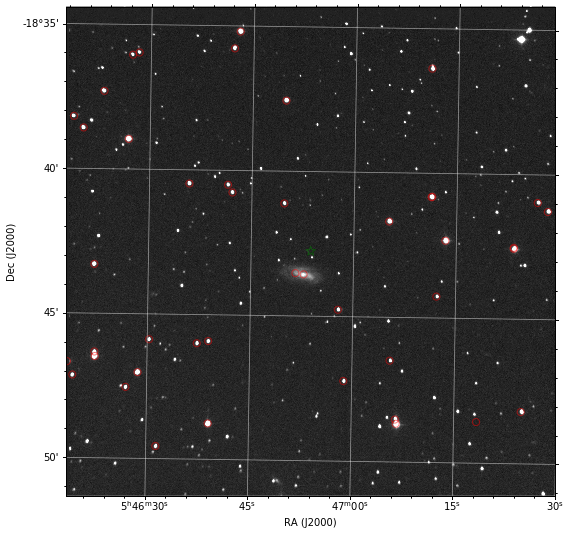

In [33]:
fig = aplpy.FITSFigure(hdulist[0])
fig.show_grayscale()
fig.add_grid()
fig.show_markers(ra_refobjs, dec_refobjs, layer='marker_set_1', edgecolor='red',
                facecolor='none', marker='o', s=50, alpha=0.5)
fig.show_markers(frame_center.ra.degree, frame_center.dec.degree, layer='marker_set_2', edgecolor='green',
                facecolor='none', marker='*', s=100, alpha=0.5)
plt.show()

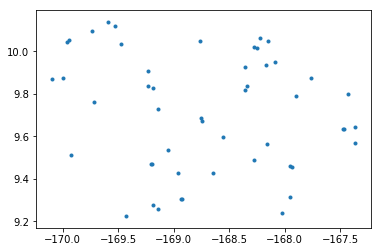

In [34]:
# The x, y of each object in the catalog according to the gnomonic projection
# I also keep a record of x,y to ra,dec pairs
xs = []
ys = []
cat_lookup = {}
for ra, dec in zip(ra_refobjs, dec_refobjs):
    xarr, yarr = Sky2Pix_Gnomonic.evaluate([ra], [dec])
    x, y = xarr[0], yarr[0]
    xs.append(x)
    ys.append(y)
    cat_lookup[(x, y)] = (ra, dec)
xs = np.array(xs)
ys = np.array(ys)

plt.scatter(xs, ys, marker=".", facecolor=None)
plt.show()

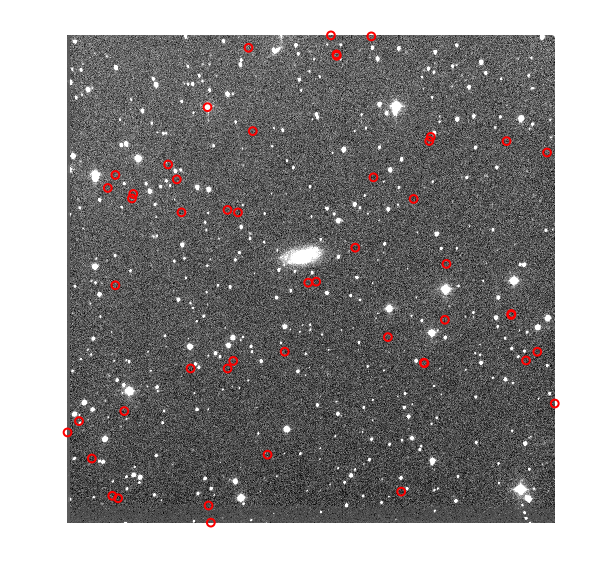

In [35]:
# This is to show that the gnomonic projection sort of resembles the sources on the image

min(xs)
dx = max(xs) - min(xs)
dy = max(ys) - min(ys)

zs = ZScaleInterval()
vmin, vmax = zs.get_limits(refimg)

plt.figure(figsize=(10, 10))
plt.imshow(refimg, cmap='gray', vmin=vmin, vmax=vmax)
plt.axis('off')

xs_scaled = -(ys - min(ys)) * refimg.shape[0] / dy + refimg.shape[0]
ys_scaled = -(xs - min(xs)) * refimg.shape[1] / dx + refimg.shape[1]

plt.scatter(xs_scaled, ys_scaled, marker="o", edgecolor='red', facecolor="none", lw=2, s=60)

plt.show()

In [36]:
xys = np.array([*zip(xs_scaled, ys_scaled)]) # x,y pairs as required by aa
t, (source, target) = aa.find_transform(xys[:20], refimg)

MaxIterError: Max iterations exceeded while trying to find acceptable transformation.